<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj29-cv-bone-fracture-detection-using-yolov8?scriptVersionId=194862210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Bone Fracture Detection using YOLOv8</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to advance automated bone fracture detection using a comprehensive dataset of X-ray images, categorized into various fracture types, such as Elbow Positive, Fingers Positive, Forearm Fracture, Humerus Fracture, Shoulder Fracture, and Wrist Positive. The dataset includes annotated images with bounding boxes or pixel-level segmentation masks, aiding in the development and evaluation of object detection algorithms like YOLO. By leveraging this dataset, the project seeks to enhance computer vision solutions for medical diagnostics, ultimately improving patient care through accurate and efficient fracture detection

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wandb disabled

W&B disabled.


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.3/872.3 kB 14.2 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
!kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project
!unzip bone-fracture-detection-computer-vision-project.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
 78%|██████████████████████████████▌        | 66.0M/84.1M [00:00<00:00, 246MB/s]
100%|███████████████████████████████████████| 84.1M/84.1M [00:00<00:00, 232MB/s]


# **Data Exploration**
----

In [6]:
train_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images'
train_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels'

test_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images'
test_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images'

val_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/images'
val_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels'

In [7]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 169
Total frames: 4148


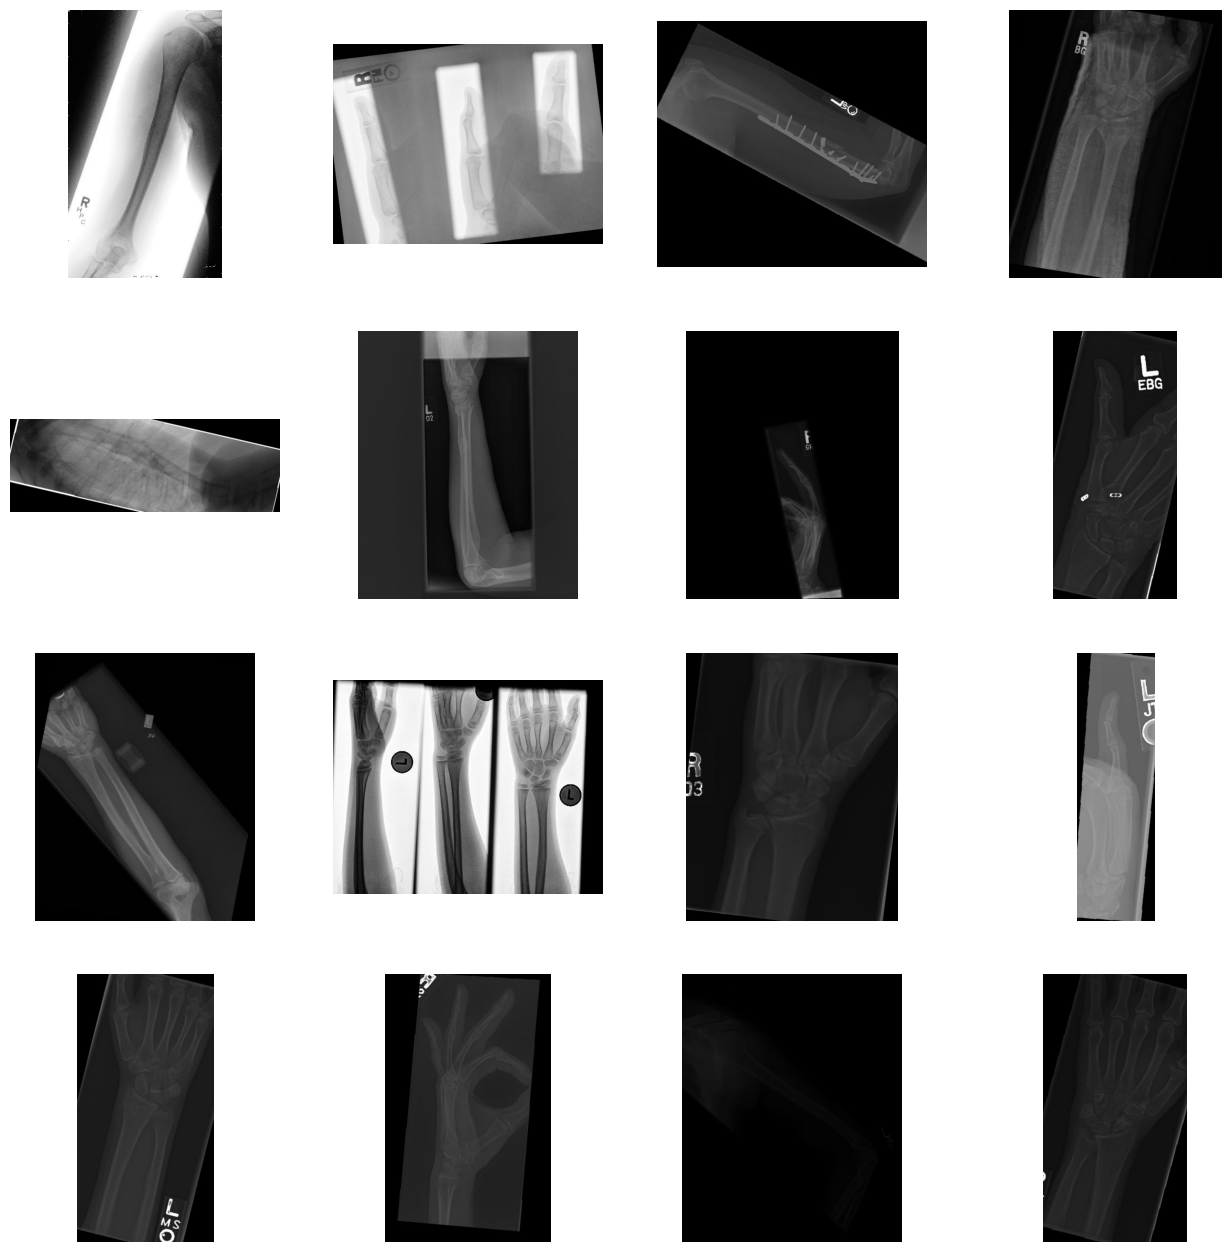

In [8]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [9]:
image = cv2.imread('/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images/distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f.jpg')

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 1024x1024 and 3 channels.


# **Modeling**
----

In [10]:
 # Loading a pretrained model
model = YOLO('yolov8s.pt')

# Training the model
model.train(data = '/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml',
            epochs = 100,
            imgsz = height,
            seed = 42,
            batch = 8,
            workers = 4,
            patience=10
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 141MB/s] 


Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]
2024-09-01 03:37:35,330	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-01 03:37:35,934	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 74.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:12<00:00, 280.60it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:01<00:00, 308.34it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.13G      2.622      9.774       2.53          5       1024: 100%|██████████| 454/454 [02:54<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.85it/s]

                   all        348        204    0.00165       0.17    0.00588    0.00185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.07G      2.462      4.799      2.506         15       1024: 100%|██████████| 454/454 [02:49<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]

                   all        348        204    0.00175      0.314    0.00514    0.00159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       4.7G      2.441      4.473      2.559          5       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]


                   all        348        204       0.35      0.017     0.0107    0.00343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.09G      2.399      4.346      2.529         13       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.92it/s]

                   all        348        204      0.577     0.0278     0.0398     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.69G      2.361      4.236      2.533          4       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]

                   all        348        204      0.397     0.0235     0.0393     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.67G      2.335      3.927      2.473          9       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.00it/s]

                   all        348        204      0.369     0.0735     0.0652     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       4.7G      2.252      3.842      2.401          7       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]

                   all        348        204      0.479       0.13     0.0752     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       4.7G      2.251      3.711      2.397         11       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.89it/s]

                   all        348        204      0.445      0.126     0.0829     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       4.7G      2.181      3.645      2.352          8       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]

                   all        348        204      0.268      0.144     0.0916     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.67G      2.184      3.502      2.369         11       1024: 100%|██████████| 454/454 [02:47<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]

                   all        348        204      0.292      0.116     0.0899     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.1G      2.133      3.396      2.285          5       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]

                   all        348        204      0.667      0.121      0.142     0.0528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.69G      2.113      3.274      2.297          5       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]

                   all        348        204       0.28      0.194       0.12     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.69G      2.116      3.221       2.28          7       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.84it/s]

                   all        348        204      0.204      0.221      0.161     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.66G      2.065       3.15      2.232          9       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]

                   all        348        204      0.381      0.213      0.151     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.09G      2.039      3.118      2.209          5       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]

                   all        348        204      0.244      0.185      0.145      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.69G      2.052      3.044      2.239         11       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]

                   all        348        204      0.323      0.173      0.139     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.69G      2.002      2.914       2.19          8       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.01it/s]

                   all        348        204       0.24      0.212      0.163     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.66G      1.999      2.848       2.18          2       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.87it/s]

                   all        348        204      0.328      0.211       0.18     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.09G      1.966      2.778      2.172          4       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]

                   all        348        204      0.155       0.21      0.159     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       4.7G      1.941      2.737      2.147          4       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]

                   all        348        204       0.21      0.259      0.185     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       4.7G      1.916      2.624      2.131          7       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]

                   all        348        204      0.237      0.242      0.166      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.67G      1.892      2.551      2.103          7       1024: 100%|██████████| 454/454 [02:47<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]

                   all        348        204      0.268      0.247       0.18     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       4.7G      1.887      2.581       2.11          9       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]

                   all        348        204      0.223      0.257      0.194     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.09G      1.881      2.561      2.099         11       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.92it/s]

                   all        348        204      0.553      0.222      0.182     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       4.7G      1.853      2.507       2.06          6       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.90it/s]

                   all        348        204      0.352       0.23      0.213     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.66G      1.801      2.369      2.023          5       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]

                   all        348        204      0.285      0.253      0.211     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       4.7G      1.816        2.4      2.045          6       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]

                   all        348        204      0.254      0.255      0.192     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       4.7G      1.787       2.27      2.011          6       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.84it/s]

                   all        348        204      0.297       0.25      0.228     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       4.7G      1.759       2.18      1.991          5       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]

                   all        348        204      0.307      0.275       0.23     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.06G      1.748      2.168      1.991          8       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]

                   all        348        204      0.224      0.274      0.192     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.09G      1.757      2.147       1.98          9       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]

                   all        348        204      0.314      0.248      0.226     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       4.7G      1.703      2.122       1.95         10       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.01it/s]

                   all        348        204       0.24      0.248      0.208     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       4.7G      1.665      1.993      1.911          4       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]

                   all        348        204       0.25        0.3      0.229     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.66G      1.639      1.876      1.882          9       1024: 100%|██████████| 454/454 [02:47<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]

                   all        348        204      0.297      0.258      0.208     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       4.7G      1.637      1.877      1.876         11       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.86it/s]

                   all        348        204      0.308      0.284      0.236     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.69G      1.596      1.865      1.852          6       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]

                   all        348        204      0.375      0.302      0.249     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.69G      1.584      1.818      1.847          9       1024: 100%|██████████| 454/454 [02:48<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]

                   all        348        204      0.366      0.251      0.244     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.66G      1.618       1.79      1.863          2       1024: 100%|██████████| 454/454 [02:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]

                   all        348        204      0.241      0.288      0.234     0.0841
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 28, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



38 epochs completed in 1.843 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  4.11it/s]


                   all        348        204      0.294      0.246      0.227     0.0919
        elbow positive         28         29     0.0872     0.0345     0.0608     0.0322
      fingers positive         41         48      0.244      0.208      0.183     0.0629
      forearm fracture         37         43       0.58      0.581      0.489      0.231
               humerus         31         36      0.403      0.417      0.417      0.145
     shoulder fracture         19         20      0.308        0.2      0.165     0.0623
        wrist positive         17         28       0.14     0.0357     0.0437     0.0183
Speed: 0.4ms preprocess, 10.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7da004121480>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

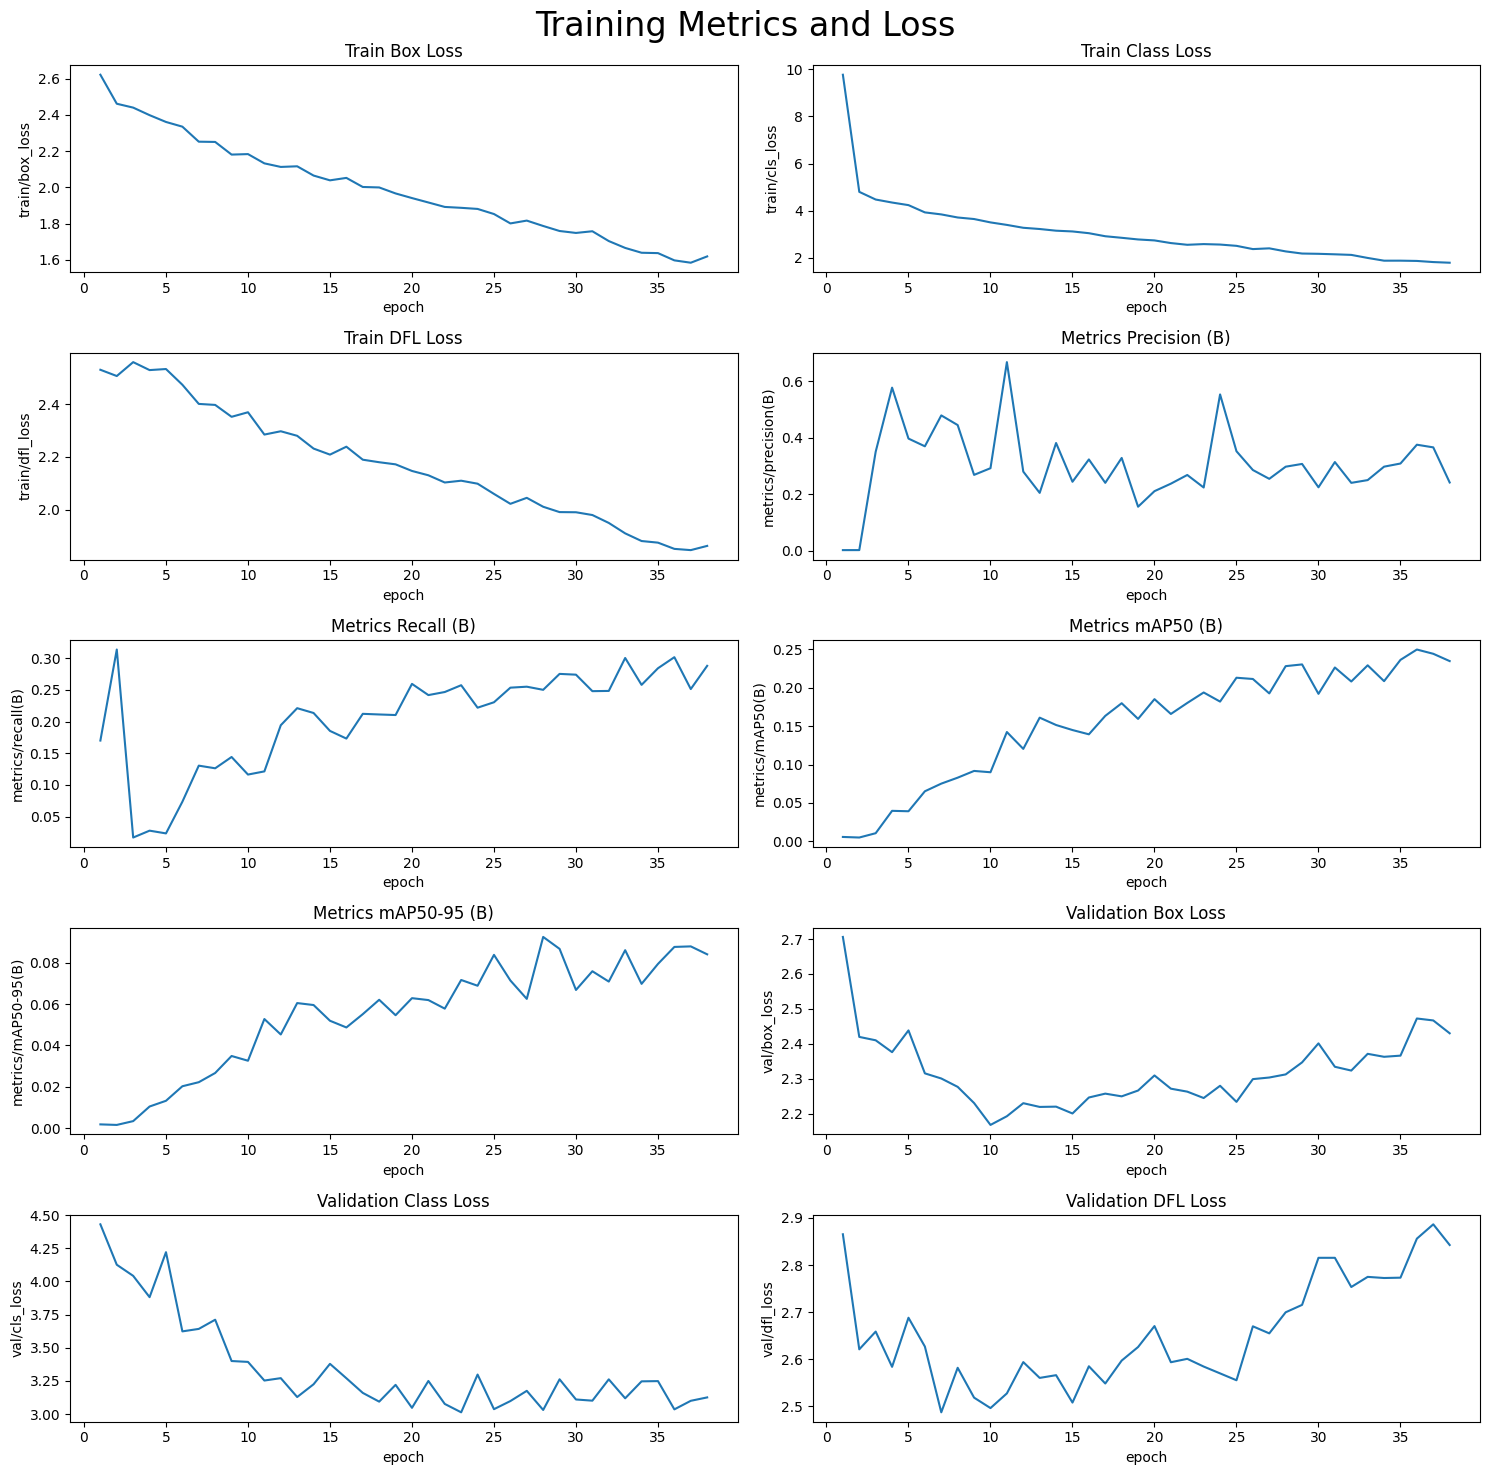

In [11]:
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# **Evaluation**
----

In [12]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/labels... 169 images, 86 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 214.54it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


                   all        169         96       0.35       0.16      0.247      0.114
        elbow positive         13         17          0          0          0          0
      fingers positive         22         27      0.207     0.0741      0.109      0.038
      forearm fracture         13         14      0.571      0.286      0.475      0.243
               humerus         14         15      0.459        0.2      0.298      0.119
     shoulder fracture         15         17      0.364      0.235      0.227      0.058
        wrist positive          6          6        0.5      0.167      0.374      0.224
Speed: 0.9ms preprocess, 13.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


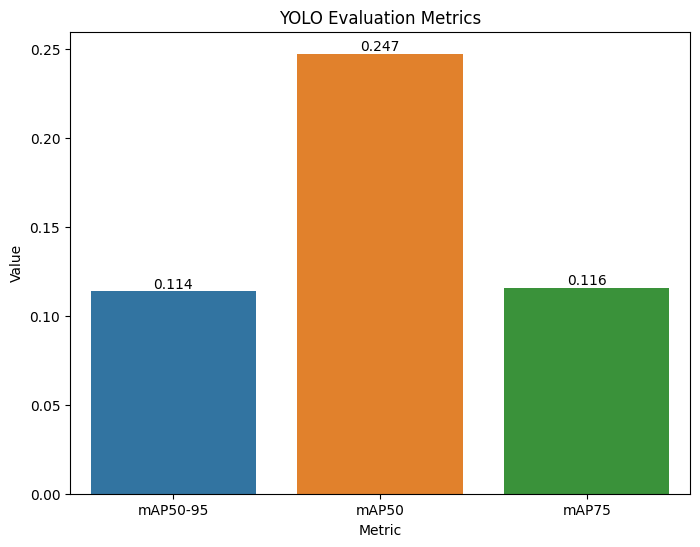

In [13]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

**Confusion Matrix**

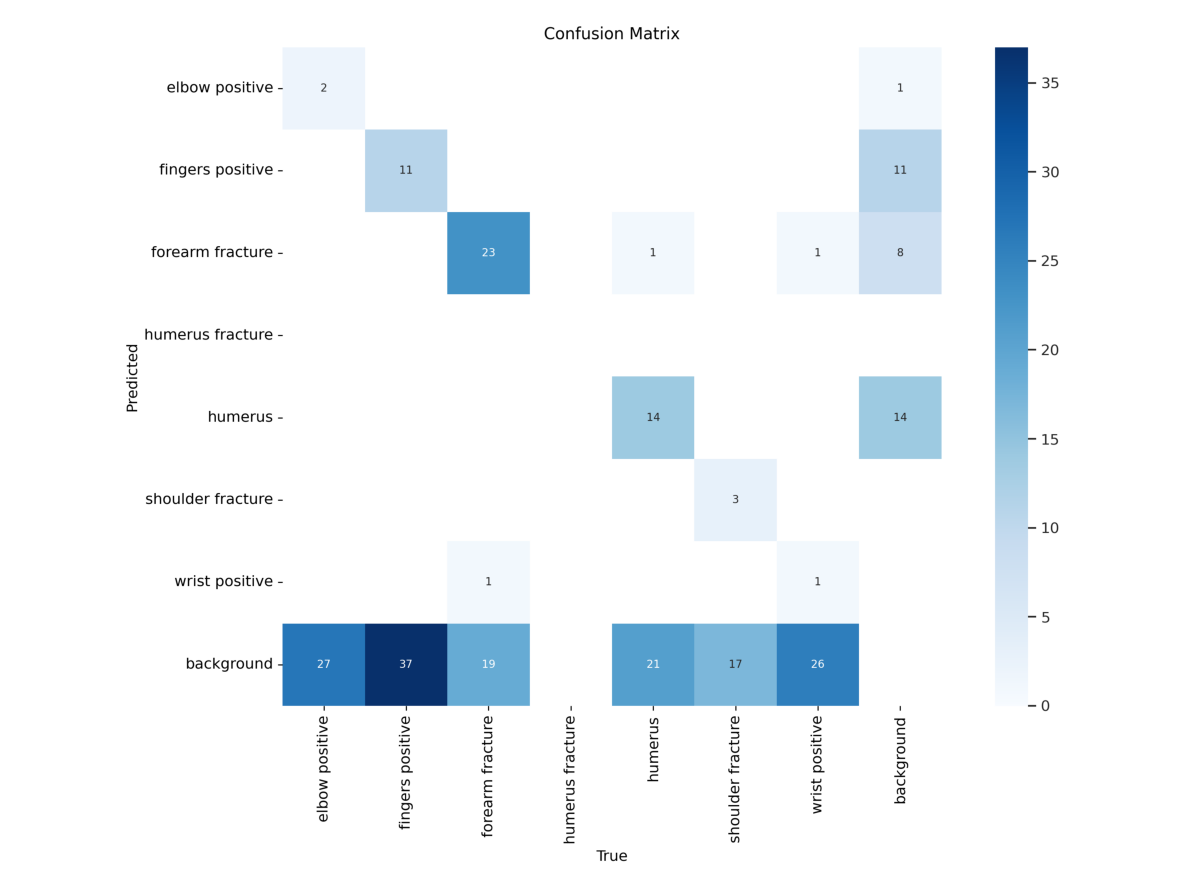

In [14]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# **Making Predictions on Test Images**
---

In [15]:
#Function to perform ship detections
def ship_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 512x1024 (no detections), 61.7ms
Speed: 4.9ms preprocess, 61.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 1024)

0: 1024x320 2 forearm fractures, 54.1ms
Speed: 2.4ms preprocess, 54.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 320)

0: 1024x480 (no detections), 55.5ms
Speed: 3.8ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 480)

0: 864x1024 (no detections), 52.6ms
Speed: 6.2ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 864, 1024)

0: 1024x384 (no detections), 52.9ms
Speed: 3.5ms preprocess, 52.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 384)

0: 1024x832 (no detections), 54.3ms
Speed: 9.1ms preprocess, 54.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x864 1 shoulder fracture, 51.4ms
Speed: 6.1ms preprocess, 51.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 864)

0: 1024x832 (no detections), 13.1ms
Speed: 4.7

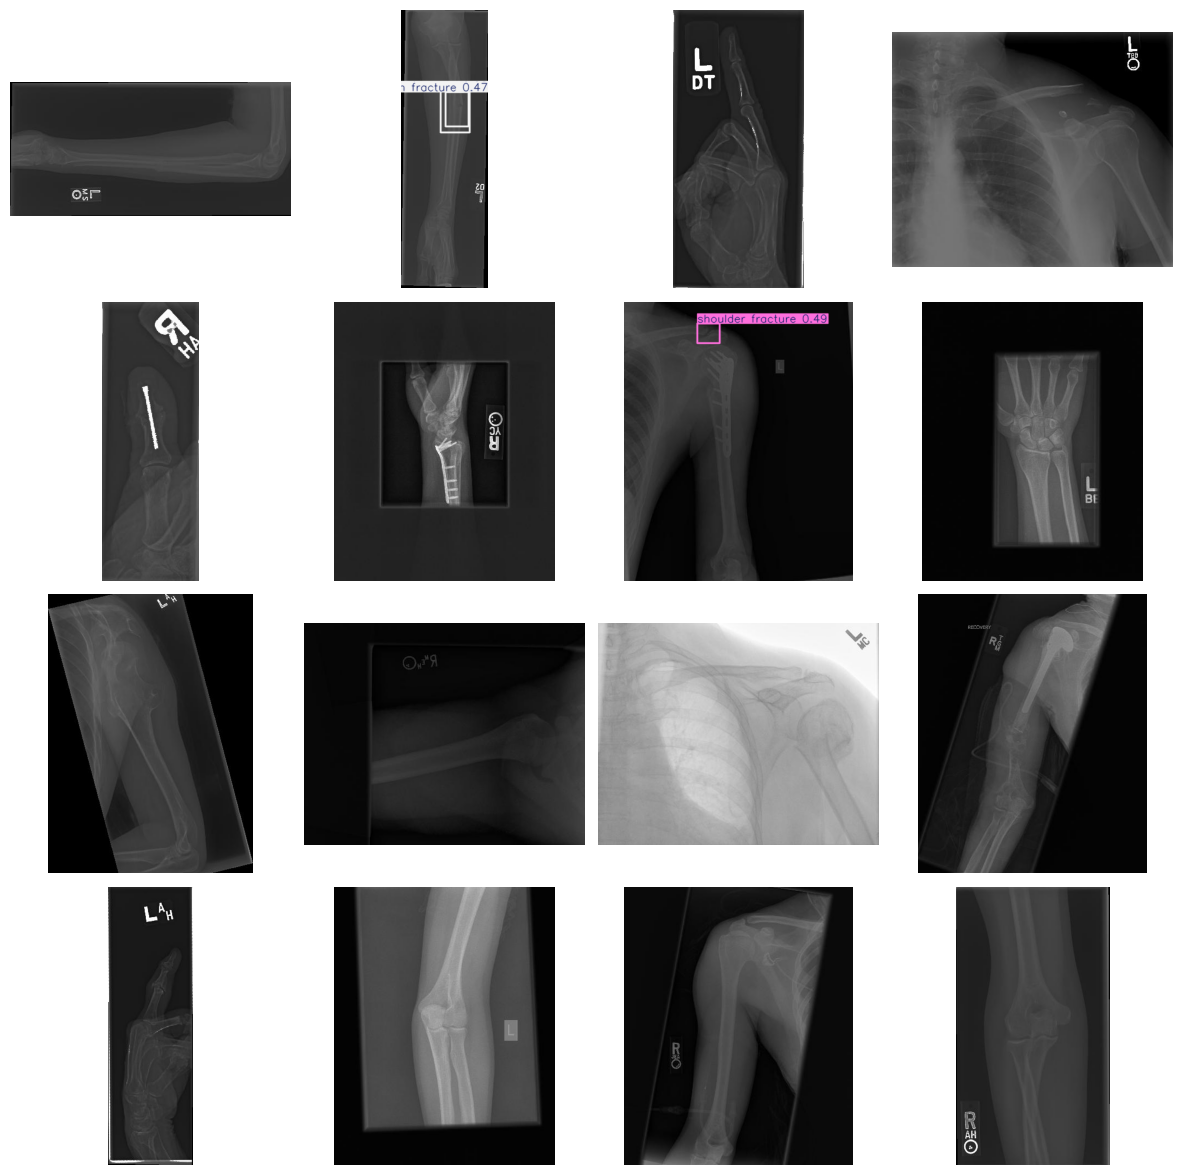

In [16]:
import random

# Define the directory where the custom images are stored
custom_image_dir = test_images

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)